# Wavelet filtering 10m Marques silico

* **Approach**:
    * We compared sorting on wavelet-filtered traces and butterworth-filtered traces for the silico marques experiment, on a 5 min sample, for speed.
        * their single unit and multi-unit yields.
        * their unit sorting accuracies curves

* **Method**
    * <u>no KS3 butterworth filtering</u>: skip_preprocessing=False, comment the filter commands in Kilosort3's `gpufilter.m` file
    * <u>no drift correction</u>:
    * <u>detection_threshold=138</u> calibrated to maximize spike detection (w/o mexWtW2 max variable size crash):
    * notes:
        * KS3 crashes with default parameters because the number of spikes detected is beyond the Maximum variable size allowed on the device (in mexWtW2).
        * we skip drift correction (drift_correction=False), else "Error using histcounts - Expected input number 2, edges, to be monotonically increasing".

* to skip preprocessing, we need to comment the filter commands in Kilosort3's `gpufilter.m` file (skip_preprocessing=True crashes because the whitening commands in preprocessDataSub are needed, and it skips them)

* **Tests:**
    * det_thresh = 50 - lower acc
    * det_thresh = 80 - lower acc
    * det_thresh = 138 -> acc = 4%
    * det_thresh = 100 - lower acc
    * det_thresh = 140 ... running (2159976)   
    * det_thresh = 150 ...crashed (2159971) 
    * allprojthresh = 4 - lower (2159974)
    * allprojthresh = 1 ....running (2160053)
    * allprojthresh = [4,4] and "preclust_threshold": 1 - lower (2160062)    
    * allprojthresh = [4,4] and lam=10 ....running (2160065)    
    
* **Obs:**
    * sort 10m wf-recording produces 3.8% acc vs. 5% for butt-

### Setup 

activate spikeinterface0_100

In [17]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
from matplotlib import pyplot as plt
import spikeinterface.full as si
import spikeinterface.extractors as se 
from spikeinterface import comparison
import spikeinterface.preprocessing as spre

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config

# SETUP DATASET COMFIG
# full 40 min recording 
data_conf, param_conf = get_config("silico_neuropixels", "concatenated").values()
RAW_PATH = data_conf["probe_wiring"]["output"]
PREP_PATH = data_conf["preprocessing"]["output"]["trace_file_path"]
PREP_PATH_W = data_conf["preprocessing"]["output"]["wavelet_trace_file_path"]
SORTING_TRUE_PATH = data_conf['sorting']['simulation']['ground_truth']['output']
SORTING_PATH_BUTT = data_conf['sorting']['sorters']['kilosort3']['output']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-05-02 13:35:07,633 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-02 13:35:07,671 - root - utils.py - get_config - INFO - Reading experiment config. - done


### (16m) Save 10m wavelet-filtered recording

* traces data type should be int16 (faster, cheaper)
* load entire recording, copy first 10 min and save for sorting

In [11]:
# get Recording extractors (as int16)
Prepro_w_full = si.load_extractor(PREP_PATH_W)

# copy 10 min and save
end_frame_for_10_min = 40000 * 60 * 10
Prepro_w_10m = Prepro_w_full.frame_slice(start_frame=0, end_frame=end_frame_for_10_min)
Prepro_w_10m.save(
    folder="/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/dataeng/0_silico/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/campaign/preprocessed/traces_wavelet",
    format="binary",
    overwrite=True,
    n_jobs=2,
    chunk_memory="40G",
    progress_bar=True,
)

write_binary_recording with n_jobs = 2 and chunk_size = 52083333


write_binary_recording:   0%|          | 0/1 [00:00<?, ?it/s]

BinaryFolderRecording: 384 channels - 40.0kHz - 1 segments - 24,000,000 samples 
                       600.00s (10.00 minutes) - int16 dtype - 17.17 GiB

In [ ]:
# Ground truth
SortingTrue = si.load_extractor(SORTING_TRUE_PATH)
SortingTrue = SortingTrue.frame_slice(start_frame=0, end_frame=end_frame_for_10_min)

### Detection thresh 140

In [34]:
sorting_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/sorting/0_silico/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/SortingKS3_wavlt_detth140/"

# sorting result
Sorting = si.load_extractor(sorting_path)

# accuracy
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, Sorting, exhaustive_gt=True
)
acc = matching.agreement_scores.max(axis=1).sort_values(ascending=False)
print("sorting accuracy: ", sum(acc.values >= 0.8) / len(acc.values))
print("# of well detected: ", sum(acc.values >= 0.8))
print("# sua: ", sum(Sorting.get_property("KSLabel") == "good"))
print("# mua: ", sum(Sorting.get_property("KSLabel") == "mua"))
print("number of true units: ", len(SortingTrue.unit_ids))

sorting accuracy:  0.037463976945244955
# of well detected:  52
# sua:  177
# mua:  1188
number of true units:  1388


### Detection thresh 138

In [29]:
sorting_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/sorting/0_silico/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/SortingKS3_wavlt/"

# sorting result
Sorting = si.load_extractor(sorting_path)

# accuracy
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, Sorting, exhaustive_gt=True
)
acc = matching.agreement_scores.max(axis=1).sort_values(ascending=False)
print("sorting accuracy: ", sum(acc.values >= 0.8) / len(acc.values))
print("# of well detected: ", sum(acc.values >= 0.8))
print("# sua: ", sum(Sorting.get_property("KSLabel") == "good"))
print("# mua: ", sum(Sorting.get_property("KSLabel") == "mua"))
print("number of true units: ", len(SortingTrue.unit_ids))

sorting accuracy:  0.03818443804034582
# of well detected:  53
# sua:  190
# mua:  1102
number of true units:  1388


### Detection threshold 100

In [30]:
sorting_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/sorting/0_silico/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/SortingKS3_wavlt_detth100/"

# sorting result
Sorting = si.load_extractor(sorting_path)

# accuracy
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, Sorting, exhaustive_gt=True
)
acc = matching.agreement_scores.max(axis=1).sort_values(ascending=False)
print("sorting accuracy: ", sum(acc.values >= 0.8) / len(acc.values))
print("# of well detected: ", sum(acc.values >= 0.8))
print("# sua: ", sum(Sorting.get_property("KSLabel") == "good"))
print("# mua: ", sum(Sorting.get_property("KSLabel") == "mua"))

print("number of true units: ", len(SortingTrue.unit_ids))

sorting accuracy:  0.032420749279538905
# of well detected:  45
# sua:  211
# mua:  1115
number of true units:  1388


### Detection thresh 80

In [31]:
sorting_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/sorting/0_silico/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/SortingKS3_wavlt_detth80/"

# sorting result
Sorting = si.load_extractor(sorting_path)

# accuracy
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, Sorting, exhaustive_gt=True
)
acc = matching.agreement_scores.max(axis=1).sort_values(ascending=False)
print("sorting accuracy: ", sum(acc.values >= 0.8) / len(acc.values))
print("# of well detected: ", sum(acc.values >= 0.8))
print("# sua: ", sum(Sorting.get_property("KSLabel") == "good"))
print("# mua: ", sum(Sorting.get_property("KSLabel") == "mua"))
print("number of true units: ", len(SortingTrue.unit_ids))

sorting accuracy:  0.0345821325648415
# of well detected:  48
# sua:  185
# mua:  1005
number of true units:  1388


### Detection thresh 50

In [32]:
sorting_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/sorting/0_silico/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/SortingKS3_wavlt_detth50/"

# sorting result
Sorting = si.load_extractor(sorting_path)

# accuracy
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, Sorting, exhaustive_gt=True
)
acc = matching.agreement_scores.max(axis=1).sort_values(ascending=False)
print("sorting accuracy: ", sum(acc.values >= 0.8) / len(acc.values))
print("# of well detected: ", sum(acc.values >= 0.8))
print("# sua: ", sum(Sorting.get_property("KSLabel") == "good"))
print("# mua: ", sum(Sorting.get_property("KSLabel") == "mua"))
print("number of true units: ", len(SortingTrue.unit_ids))

sorting accuracy:  0.029538904899135448
# of well detected:  41
# sua:  178
# mua:  1047
number of true units:  1388


### Allproj = 4

In [35]:
sorting_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/sorting/0_silico/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/SortingKS3_wavlt_allproj4/"

# sorting result
Sorting = si.load_extractor(sorting_path)

# accuracy
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, Sorting, exhaustive_gt=True
)
acc = matching.agreement_scores.max(axis=1).sort_values(ascending=False)
print("sorting accuracy: ", sum(acc.values >= 0.8) / len(acc.values))
print("# of well detected: ", sum(acc.values >= 0.8))
print("# sua: ", sum(Sorting.get_property("KSLabel") == "good"))
print("# mua: ", sum(Sorting.get_property("KSLabel") == "mua"))
print("number of true units: ", len(SortingTrue.unit_ids))

sorting accuracy:  0.03025936599423631
# of well detected:  42
# sua:  317
# mua:  2213
number of true units:  1388


#### allprojthresh = [4,4] and "preclust_threshold": 1

In [36]:
sorting_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/sorting/0_silico/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/SortingKS3_wavlt_allproj4_precl1/"

# sorting result
Sorting = si.load_extractor(sorting_path)

# accuracy
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, Sorting, exhaustive_gt=True
)
acc = matching.agreement_scores.max(axis=1).sort_values(ascending=False)
print("sorting accuracy: ", sum(acc.values >= 0.8) / len(acc.values))
print("# of well detected: ", sum(acc.values >= 0.8))
print("# sua: ", sum(Sorting.get_property("KSLabel") == "good"))
print("# mua: ", sum(Sorting.get_property("KSLabel") == "mua"))
print("number of true units: ", len(SortingTrue.unit_ids))

sorting accuracy:  0.02881844380403458
# of well detected:  40
# sua:  322
# mua:  2228
number of true units:  1388


### allprojthres=4, lam=10

In [37]:
sorting_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/sorting/0_silico/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/SortingKS3_wavlt_allproj4_lam10/"

# sorting result
Sorting = si.load_extractor(sorting_path)

# accuracy
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, Sorting, exhaustive_gt=True
)
acc = matching.agreement_scores.max(axis=1).sort_values(ascending=False)
print("sorting accuracy: ", sum(acc.values >= 0.8) / len(acc.values))
print("# of well detected: ", sum(acc.values >= 0.8))
print("# sua: ", sum(Sorting.get_property("KSLabel") == "good"))
print("# mua: ", sum(Sorting.get_property("KSLabel") == "mua"))
print("number of true units: ", len(SortingTrue.unit_ids))

### Load SortingExtractor

* observations:
    * 5 times more single units are isolated.
    * a lot more multi-units too

* detection_threshold: 6
    * single unit count: 610
    * mua count: 1795
* detection_threshold: 12
    * single unit count: 574
    * mua count: 1655
* detection_threshold: 138
    * prediction: x2 -> -6% thus -> -70% (184) requires increasing the threshold 23X, thus 138.
    * actual: 
        * single unit count: 175 (174 for int16)
        * mua count: 639 (657 for int16)

In [5]:
SortingW = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/SortingKS3_sample_wvlt/"
)
print("single unit count:", sum(SortingW.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingW.get_property("KSLabel") == "mua"))

single unit count: 174
mua count: 657


### Compare accuracies Butter. vs Wavelet

* Accuracies are not exact, as the ground truth is for the entire recording not the 5 first minutes.
* we plot butterworth-filtered vs. wavelet-filtered sortings with `detection_threshold=6`.

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(


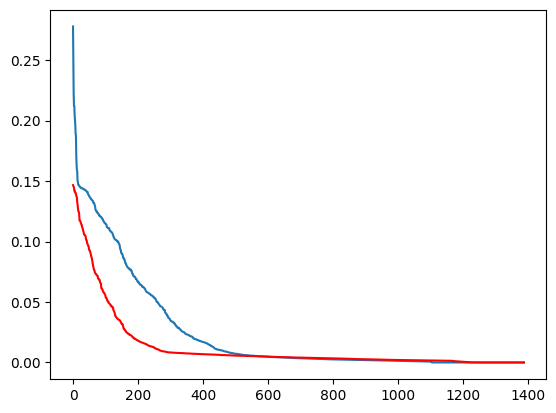

In [38]:
# load ground truth spikes and units
SortingTrue = si.load_extractor(SORTING_TRUE_PATH)

# Butterworth-filtered
# agreement score between sorted and true units
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingB, exhaustive_gt=True
)
accuracy_b = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# Wavelet-filtered
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingW, exhaustive_gt=True
)
accuracy_w = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# plot
plt.plot(accuracy_b.values)
plt.plot(accuracy_w.values, "r")

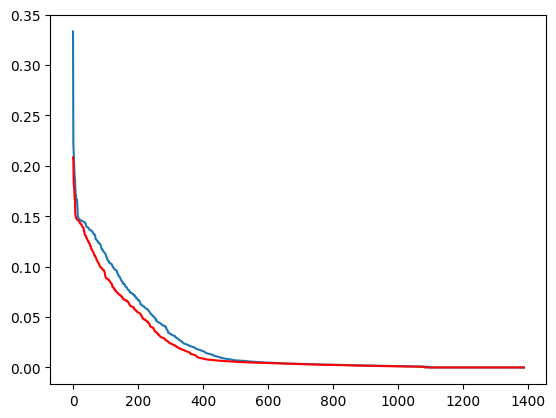

In [8]:
# load ground truth spikes and units
SortingTrue = si.load_extractor(SORTING_TRUE_PATH)

# Butterworth-filtered
# agreement score between sorted and true units
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingB, exhaustive_gt=True
)
accuracy_b = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# Wavelet-filtered
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingW, exhaustive_gt=True
)
accuracy_w = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# plot
plt.plot(accuracy_b.values)
plt.plot(accuracy_w.values, "r")

### (10m) Compare KS3 on butter vs. wavelet on the entire recording (40m)

* We disable the filtering commands in the KS3 repository, and set `skip_preprocessing` args to `False` (else it does not find any spike). Note: all other preprocessing steps are enabled (whitening, mean subtraction, common referencing...).
* We feed the waveleted-filtered recording to the KS3 sorter.

* KS3 trace is int16
* Sorting takes 1h

* detection_threshold: 138
    * single unit count: 316
    * mua count: 3149

* note: we had 5% accuracy with old KS3 on 10 min recording with Butterworth. What changed?


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(


single unit count: 335
mua count: 1349
single unit count: 316
mua count: 3149

WAVELET
sorting accuracy:  0.0007204610951008645
# of well detected:  1
number of true units:  1388

BUTTERWORTH
sorting accuracy:  0.0007204610951008645
# of well detected:  1
number of true units:  1388


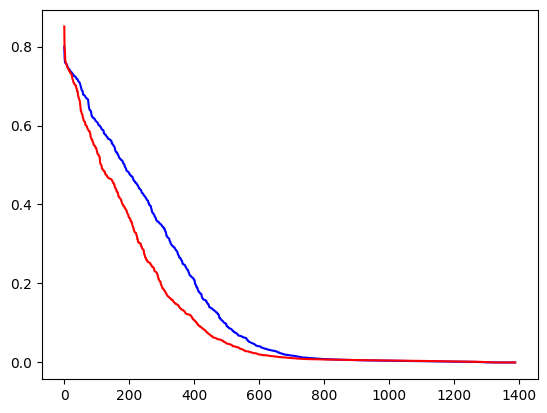

In [22]:
# get sorting extractors *****
SortingB = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/SortingKS3/"
)
print("single unit count:", sum(SortingB.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingB.get_property("KSLabel") == "mua"))

SortingW = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/SortingKS3_wavlt/"
)
print("single unit count:", sum(SortingW.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingW.get_property("KSLabel") == "mua"))


# Get accuracies *****
# load ground truth spikes and units
SortingTrue = si.load_extractor(SORTING_TRUE_PATH)

# butterworth-filtered
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingB, exhaustive_gt=True
)
accuracy_b = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# Wavelet-filtered
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingW, exhaustive_gt=True
)
accuracy_w = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# plot
plt.plot(accuracy_b.values, "b")
plt.plot(accuracy_w.values, "r")

# report sorting accuracy
print("\nWAVELET")
print("sorting accuracy: ", sum(accuracy_b.values >= 0.8) / len(accuracy_b.values))
print("# of well detected: ", sum(accuracy_b.values >= 0.8))
print("number of true units: ", len(SortingTrue.unit_ids))

print("\nBUTTERWORTH")
print("sorting accuracy: ", sum(accuracy_w.values >= 0.8) / len(accuracy_w.values))
print("# of well detected: ", sum(accuracy_w.values >= 0.8))
print("number of true units: ", len(SortingTrue.unit_ids))

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(


single unit count: 228
mua count: 631
single unit count: 335
mua count: 1349
single unit count: 316
mua count: 3149

WAVELET
sorting accuracy:  0.0007204610951008645
# of well detected:  1
number of true units:  1388

BUTTERWORTH 10m
sorting accuracy:  0.0
# of well detected:  0
number of true units:  1388

BUTTERWORTH
sorting accuracy:  0.0007204610951008645
# of well detected:  1
number of true units:  1388


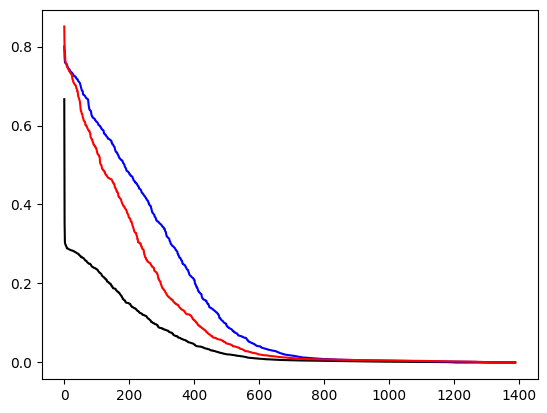

In [28]:
# get sorting extractors *****

# Butterworth 10 min
SortingB10m = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/sorting/0_silico/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/SortingKS3/"
)
print("single unit count:", sum(SortingB10m.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingB10m.get_property("KSLabel") == "mua"))

# Butter. entire
SortingB = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/SortingKS3/"
)
print("single unit count:", sum(SortingB.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingB.get_property("KSLabel") == "mua"))

# wavelet
SortingW = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/SortingKS3_wavlt/"
)
print("single unit count:", sum(SortingW.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingW.get_property("KSLabel") == "mua"))


# Get accuracies *****
# load ground truth spikes and units
SortingTrue = si.load_extractor(SORTING_TRUE_PATH)

# butterworth 10m
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingB10m, exhaustive_gt=True
)
accuracy_b10m = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# butterworth entire
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingB, exhaustive_gt=True
)
accuracy_b = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# Wavelet-filtered
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingW, exhaustive_gt=True
)
accuracy_w = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# plot
plt.plot(accuracy_b10m.values, "k")
plt.plot(accuracy_b.values, "b")
plt.plot(accuracy_w.values, "r")

# report sorting accuracy
print("\nWAVELET")
print("sorting accuracy: ", sum(accuracy_b.values >= 0.8) / len(accuracy_b.values))
print("# of well detected: ", sum(accuracy_b.values >= 0.8))
print("number of true units: ", len(SortingTrue.unit_ids))

print("\nBUTTERWORTH 10m")
print(
    "sorting accuracy: ", sum(accuracy_b10m.values >= 0.8) / len(accuracy_b10m.values)
)
print("# of well detected: ", sum(accuracy_b10m.values >= 0.8))
print("number of true units: ", len(SortingTrue.unit_ids))

print("\nBUTTERWORTH")
print("sorting accuracy: ", sum(accuracy_w.values >= 0.8) / len(accuracy_w.values))
print("# of well detected: ", sum(accuracy_w.values >= 0.8))
print("number of true units: ", len(SortingTrue.unit_ids))

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(


single unit count: 228
mua count: 631
single unit count: 228
mua count: 613
single unit count: 335
mua count: 1349

BUTTERWORTH
sorting accuracy:  0.0007204610951008645
# of well detected:  1
number of true units:  1388

BUTTERWORTH 10m
sorting accuracy:  0.05343511450381679
# of well detected:  70
number of true units:  1388

BUTTERWORTH 10m01005
sorting accuracy:  0.05267175572519084
# of well detected:  69


AttributeError: 'Series' object has no attribute 'unit_ids'

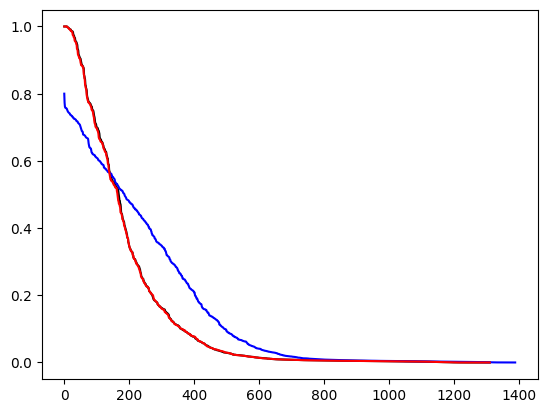

In [32]:
# get sorting extractors *****

# Butterworth 10 min (done with si0961)
SortingB10m = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/sorting/0_silico/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/SortingKS3/"
)
print("single unit count:", sum(SortingB10m.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingB10m.get_property("KSLabel") == "mua"))

# Butterworth 10 min (done with si01005)
SortingB10m01005 = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/sorting/0_silico/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/SortingKS3_si01005/"
)
print("single unit count:", sum(SortingB10m01005.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingB10m01005.get_property("KSLabel") == "mua"))

# Butter. entire (done with si0961)
SortingB = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/SortingKS3/"
)
print("single unit count:", sum(SortingB.get_property("KSLabel") == "good"))
print("mua count:", sum(SortingB.get_property("KSLabel") == "mua"))

# wavelet (done with si01005 - incompatbility)
# SortingW = si.load_extractor(
#     "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/SortingKS3_wavlt/"
# )
# print("single unit count:", sum(SortingW.get_property("KSLabel") == "good"))
# print("mua count:", sum(SortingW.get_property("KSLabel") == "mua"))


# Get accuracies *****
# load ground truth spikes and units (done with si0961)
SortingTrue = si.load_extractor(SORTING_TRUE_PATH)

# butterworth 10m
SortingTrue10m = si.load_extractor(SORTING_TRUE_PATH_10m)
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue10m, SortingB10m, exhaustive_gt=True
)
accuracy_b10m = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# butterworth 10m01005
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue10m, SortingB10m01005, exhaustive_gt=True
)
accuracy_b10m01005 = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# butterworth entire
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue, SortingB, exhaustive_gt=True
)
accuracy_b = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# Wavelet-filtered
# matching = comparison.compare_sorter_to_ground_truth(
#     SortingTrue, SortingW, exhaustive_gt=True
# )
# accuracy_w = matching.agreement_scores.max(axis=1).sort_values(ascending=False)

# plot
plt.plot(accuracy_b10m.values, "k")
plt.plot(accuracy_b.values, "b")
plt.plot(accuracy_b10m01005.values, "r")

# plt.plot(accuracy_w.values, "r")

# report sorting accuracy
print("\nBUTTERWORTH")
print("sorting accuracy: ", sum(accuracy_b.values >= 0.8) / len(accuracy_b.values))
print("# of well detected: ", sum(accuracy_b.values >= 0.8))
print("number of true units: ", len(SortingTrue.unit_ids))


print("\nBUTTERWORTH 10m")
print(
    "sorting accuracy: ", sum(accuracy_b10m.values >= 0.8) / len(accuracy_b10m.values)
)
print("# of well detected: ", sum(accuracy_b10m.values >= 0.8))
print("number of true units: ", len(SortingTrue.unit_ids))

print("\nBUTTERWORTH 10m01005")
print(
    "sorting accuracy: ",
    sum(accuracy_b10m01005.values >= 0.8) / len(accuracy_b10m01005.values),
)
print("# of well detected: ", sum(accuracy_b10m01005.values >= 0.8))
print("number of true units: ", len(accuracy_b10m01005.unit_ids))

# print("\nWAVELET")
# print("sorting accuracy: ", sum(accuracy_w.values >= 0.8) / len(accuracy_w.values))
# print("# of well detected: ", sum(accuracy_w.values >= 0.8))
# print("number of true units: ", len(SortingTrue.unit_ids))

In [2]:
# butterworth 10m
SortingB10m = si.load_extractor(
    "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/sorting/0_silico/neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18/be011315-9555-493e-a59c-27f42d1058ed/SortingKS3/"
)
matching = comparison.compare_sorter_to_ground_truth(
    SortingTrue10m, SortingB10m, exhaustive_gt=True
)
accuracy_b10m = matching.agreement_scores.max(axis=1).sort_values(ascending=False)


print("\nBUTTERWORTH 10m")
print(
    "sorting accuracy: ",
    sum(accuracy_b10m.values >= 0.8) / len(accuracy_b10m.values),
)
print("# of well detected: ", sum(accuracy_b10m.values >= 0.8))
print("number of true units: ", len(SortingTrue10m.unit_ids))

single unit count 354
mua count: 1058
single unit count 227
mua count: 437


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(



BUTTERWORTH 10m
sorting accuracy:  0.05343511450381679
# of well detected:  70
number of true units:  1310

BUTTERWORTH 10m rotd 10m....
sorting accuracy:  0.04122137404580153
# of well detected:  54
number of true units:  1310

BUTTERWORTH rotd full
sorting accuracy:  0.0
# of well detected:  0
number of true units:  1388


### (6m) Save as int16 to speed up sorting

In [5]:
Wired = si.load_extractor(WIRED_PATH_10m)

# convert to int16
Wired = spre.astype(Wired, "int16")

# save
Wired.save(
    folder=WIRED_PATH_10m_int16,
    format="binary",
    n_jobs=4,
    chunk_memory="40G",
    overwrite=True,
)

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/binaryrecordingextractor.py:78: UserWarning: `num_chan` is to be deprecated in version 0.100, please use `num_channels` instead
  warnings.warn("`num_chan` is to be deprecated in version 0.100, please use `num_channels` instead")


write_binary_recording with n_jobs = 4 and chunk_size = 52083333


write_binary_recording:   0%|          | 0/1 [00:00<?, ?it/s]

BinaryFolderRecording: 384 channels - 40.0kHz - 1 segments - 23,519,988 samples 
                       588.00s (9.80 minutes) - int16 dtype - 16.82 GiB